## Training pipeline

In [ ]:
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", module="IPython")

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.append(project_root)
# Set the environment variables from the file <root_dir>/.env
from backend.models import config
settings = config.HopsworksSettings(_env_file=f".env")

HopsworksSettings initialized!


In [18]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from backend import util
import json

import warnings
warnings.filterwarnings("ignore")

Load project.

In [19]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

2025-11-15 11:40:56,119 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-15 11:40:56,122 INFO: Initializing external client
2025-11-15 11:40:56,123 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-15 11:40:57,409 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279162


In [20]:
country = locals().get("country", settings.AQICN_COUNTRY)
city = locals().get("city", settings.AQICN_CITY)
street = locals().get("street", settings.AQICN_STREET)
lag_feature = locals().get("lag_feature", "pm25_rolling_3d")

### Prepare the data

In [ ]:
air_quality_fg = fs.get_feature_group(
    name='air_quality_with_all_lags',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [24]:
from hsfs.feature import Feature

if lag_feature == 'pm25':
    selected_features = air_quality_fg.select(
        ['pm25', 'date']
    ).join(
        weather_fg.select_features(), on=['city']
    )
else:
    selected_features = air_quality_fg.select(
        ['pm25', lag_feature, 'date']
    ).join(
        weather_fg.select_features(), on=['city']
    )

2025-11-15 11:41:00,360 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


In [25]:
feature_view = fs.get_or_create_feature_view(
    name=f'air_quality_fv_{lag_feature}',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279162/fs/1265774/fv/air_quality_fv_pm25/version/1


In [26]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [27]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start,
    primary_key=True,
)
X_train

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.77s) 


,date,lescalableframes_air_quality_with_all_lags_1_country,lescalableframes_air_quality_with_all_lags_1_city,lescalableframes_air_quality_with_all_lags_1_street,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,lescalableframes_weather_1_city
0,2017-05-28 00:00:00+00:00,estonia,tallinn,rahu,20.497751,1.5,20.291357,255.617081,tallinn
1,2017-05-29 00:00:00+00:00,estonia,tallinn,rahu,14.410249,0.0,18.129137,345.427307,tallinn
2,2017-05-30 00:00:00+00:00,estonia,tallinn,rahu,10.778999,9.1,18.511143,188.213547,tallinn
3,2017-05-31 00:00:00+00:00,estonia,tallinn,rahu,11.329000,3.3,15.815435,305.566833,tallinn
4,2018-05-15 00:00:00+00:00,estonia,tallinn,rahu,18.206083,0.0,11.570515,62.949455,tallinn
...,...,...,...,...,...,...,...,...,...
22773,2025-04-30 00:00:00+00:00,sweden,stockholm,jultomtestegen,8.947750,1.6,25.369785,313.522400,stockholm
22774,2025-04-30 00:00:00+00:00,sweden,stockholm,nacka,8.947750,1.6,25.369785,313.522400,stockholm
22775,2025-04-30 00:00:00+00:00,sweden,stockholm,hägersten,8.947750,1.6,25.369785,313.522400,stockholm
22776,2025-04-30 00:00:00+00:00,sweden,stockholm,lundströmsgata,8.947750,1.6,25.369785,313.522400,stockholm


In [14]:
X_features = X_train[
    (X_train["lescalableframes_air_quality_with_all_lags_1_country"] == country) &
    (X_train["lescalableframes_air_quality_with_all_lags_1_city"] == city) &
    (X_train["lescalableframes_air_quality_with_all_lags_1_street"] == street)
].drop(columns=['date', 
    'lescalableframes_air_quality_with_all_lags_1_country',
    'lescalableframes_air_quality_with_all_lags_1_city',
    'lescalableframes_air_quality_with_all_lags_1_street',
    'lescalableframes_weather_1_city'
])[3:]
X_test_features = X_test[
    (X_test["lescalableframes_air_quality_with_all_lags_1_country"] == country) &
    (X_test["lescalableframes_air_quality_with_all_lags_1_city"] == city) &
    (X_test["lescalableframes_air_quality_with_all_lags_1_street"] == street)
].drop(columns=['date',
    'lescalableframes_air_quality_with_all_lags_1_country',
    'lescalableframes_air_quality_with_all_lags_1_city',
    'lescalableframes_air_quality_with_all_lags_1_street',
    'lescalableframes_weather_1_city'
])

In [15]:
X_features

,pm25_rolling_3d,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
3,23.333334,11.329000,3.3,15.815435,305.566833
4,22.666666,18.206083,0.0,11.570515,62.949455
5,30.333334,18.751915,0.0,17.026896,44.999886
6,45.000000,12.716498,3.3,19.137648,7.780642
7,56.000000,12.845666,0.1,21.252199,0.214787
...,...,...,...,...,...
2049,17.000000,4.939417,0.0,13.752048,326.839844
2050,13.000000,8.479001,0.0,18.083506,211.242142
2051,10.666667,11.935249,0.1,25.084663,258.606140
2052,10.000000,11.904000,0.0,20.170443,301.991791


In [ ]:
y_train = y_train[
    (X_train["lescalableframes_air_quality_with_all_lags_1_country"] == country) &
    (X_train["lescalableframes_air_quality_with_all_lags_1_city"] == city) &
    (X_train["lescalableframes_air_quality_with_all_lags_1_street"] == street)
][3:]
y_train

,pm25
3,19.0
4,55.0
5,61.0
6,52.0
7,35.0
...,...
2049,9.0
2050,8.0
2051,13.0
2052,12.0


In [ ]:
y_test = y_test[
    (X_test["lescalableframes_air_quality_with_all_lags_1_country"] == country) &
    (X_test["lescalableframes_air_quality_with_all_lags_1_city"] == city) &
    (X_test["lescalableframes_air_quality_with_all_lags_1_street"] == street)
]
y_test

,pm25
2054,16.0
2055,14.0
2056,16.0
2057,9.0
2058,7.0
...,...
2247,12.0
2248,10.0
2249,13.0
2250,9.0


### Train the model

In [ ]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 121.72187
R squared: 0.029705326226615147


In [ ]:
df = y_test
df['predicted_pm25'] = y_pred

In [ ]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
2054,16.0,19.724186,2025-05-01 00:00:00+00:00
2055,14.0,13.663019,2025-05-02 00:00:00+00:00
2056,16.0,10.281109,2025-05-03 00:00:00+00:00
2057,9.0,18.316647,2025-05-04 00:00:00+00:00
2058,7.0,7.052437,2025-05-05 00:00:00+00:00


In [ ]:
street_new = street.replace('-', '_')
street_new = street_new.replace('ä', 'ae')
street_new = street_new.replace('ö', 'oe')
street_new = street_new.replace('å', 'oa')

In [ ]:
model_dir = f"backend/air_quality_models/" + (lag_feature + "/" + country + "_" + city + "_" + street_new)
if not os.path.exists(model_dir):
    os.makedirs(model_dir, exist_ok=True)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

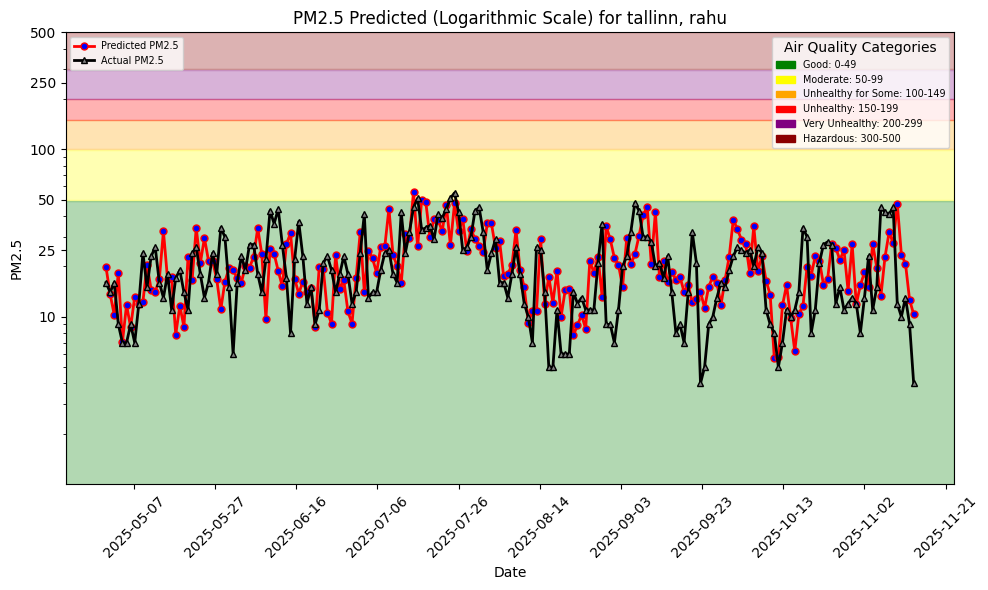

In [ ]:
file_path = images_dir + "/pm25_hindcast" + "_" + country + "_" + city + "_" + street_new + ".png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

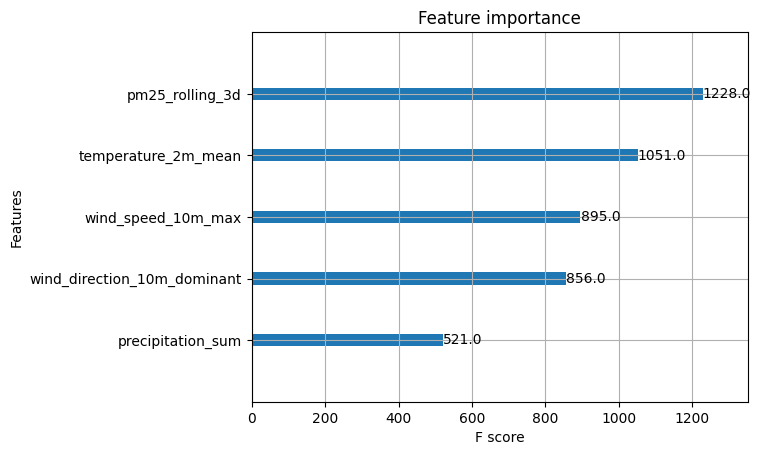

In [ ]:
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance" + "_" + country + "_" + city + "_" + street_new + ".png"
plt.savefig(feature_importance_path)
plt.show()

### Saving the model

In [ ]:
xgb_regressor.save_model(model_dir + "/model" + "_"  + country + "_" + city + "_" + street_new + ".json")

In [ ]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [ ]:
print(model_dir)

/Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/air_quality_models/pm25_rolling_3d/estonia_tallinn_rahu


In [ ]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model" + "_" + lag_feature + "_"  + country + "_" + city + "_" + street_new, 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/air_quality_models/pm25_…

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/air_quality_models/pm25_…

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/air_quality_models/pm25_…

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/notebooks/model_schema.j…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279162/models/air_quality_xgboost_model_estonia_tallinn_rahu/2


Model(name: 'air_quality_xgboost_model_estonia_tallinn_rahu', version: 2)